In this notebook we will look into the revenue level and take rate of each merchants from the top 3 industries we selected

In [1]:
import os
import sys  
from pathlib import Path
curr_path = str(Path(os.getcwd()).parent)
sys.path.append(curr_path)
import seaborn as sns

from scripts.constants import *
from scripts.plotting import *
from scripts.misc_changes import *

import matplotlib.pyplot as plt


In [2]:
spark = create_spark()

your 131072x1 screen size is bogus. expect trouble
23/10/13 13:19:33 WARN Utils: Your hostname, DESKTOP-IUQJ8D5 resolves to a loopback address: 127.0.1.1; using 172.23.100.88 instead (on interface eth0)
23/10/13 13:19:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/13 13:19:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/13 13:19:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/13 13:19:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
PREFIX = "."

In [4]:
# mapped_industry.csv contains all the merchants and the industry they belong to

df = spark.read.csv(PREFIX + INDUSTRY_MAPPING_PATH, header=True, inferSchema=True)

In [5]:
def categorise_industry(sdf: DataFrame) -> dict:
    """
    Categoriese the merchants by their respective industry
    - Parameters
        - sdf: spark dataframe contains information about the merchant and its industry
    - Returns
        - Dictionary containing the induustries as the key and merchnat information as the value
    """
    industry_category = {}
    industry_list = sorted(df.select(MAPPED_INDUSTRY).distinct().collect())
    for row in industry_list:
        x = row[MAPPED_INDUSTRY]
        industry_category[x] = sdf.filter(df[MAPPED_INDUSTRY] == x)
    
    return industry_category

In [6]:
industry_dict = categorise_industry(df)

Reading the csv file with the industrys and the scores and reading the top 3 industried to get the merchants

In [7]:
industry_ranking = pd.read_csv(PREFIX + SORTED_INDUSTRY_PATH, index_col=False)

In [8]:
top_three_industry = industry_ranking[MAPPED_INDUSTRY].head(3)

In [9]:
industry_1 = industry_dict[top_three_industry[0]].toPandas()
industry_2 = industry_dict[top_three_industry[1]].toPandas()
industry_3 = industry_dict[top_three_industry[2]].toPandas()

In [10]:
# combining the merchants from the three indutries to analyse their revenue and take rate

top_three_industry_merchants = pd.concat([industry_1, industry_2, industry_3], ignore_index=True)
top_three_industry_merchants

,name,merchant_abn,revenue_level,take_rate,industry_tags,MappedIndustry
0,Sed Et Libero PC,10651113986,b,3.25,tent awning,X
1,Scelerisque Scelerisque Ltd,11215815177,b,4.77,tent awning,X
2,Vitae Aliquam Incorporated,11700214701,a,6.20,tent awning,X
3,Et Eros Limited,12133839110,a,6.69,tent awning,X
4,Amet Orci Industries,12927607277,d,0.83,tent awning,X
...,...,...,...,...,...,...
550,Enim Mi LLC,97353800246,b,3.99,digital goods books movies music,F
551,Interdum Ligula Eu Corp.,98722839745,b,4.61,digital goods books movies music,F
552,Non Enim Corp.,99115883676,b,3.65,digital goods books movies music,F
553,Non Ante Inc.,99217762645,b,5.05,digital goods books movies music,F


Revenue Analysis of each merchants

In [11]:
count_revenue = top_three_industry_merchants.groupby(REVENUE_LEVEL)[NAME].count().reset_index(name='Count')
count_revenue

,revenue_level,Count
0,a,253
1,b,175
2,c,108
3,d,12
4,e,7


Since we know revenue level 'e' is the highest, we would prefer merchants with revenue level 'e' hence giving more weight to 'e' and least weight to 'a' revenue level.

In [12]:
revenue_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5}

Instead of aphabets, we cna use numbers for easier calculation and analysis

In [13]:
top_three_industry_merchants[REVENUE_LEVEL] = top_three_industry_merchants[REVENUE_LEVEL].replace(revenue_mapping)

In [14]:
top_three_industry_merchants

,name,merchant_abn,revenue_level,take_rate,industry_tags,MappedIndustry
0,Sed Et Libero PC,10651113986,2,3.25,tent awning,X
1,Scelerisque Scelerisque Ltd,11215815177,2,4.77,tent awning,X
2,Vitae Aliquam Incorporated,11700214701,1,6.20,tent awning,X
3,Et Eros Limited,12133839110,1,6.69,tent awning,X
4,Amet Orci Industries,12927607277,4,0.83,tent awning,X
...,...,...,...,...,...,...
550,Enim Mi LLC,97353800246,2,3.99,digital goods books movies music,F
551,Interdum Ligula Eu Corp.,98722839745,2,4.61,digital goods books movies music,F
552,Non Enim Corp.,99115883676,2,3.65,digital goods books movies music,F
553,Non Ante Inc.,99217762645,2,5.05,digital goods books movies music,F


In [15]:
# checking there are no merchants repeating

top_three_industry_merchants[NAME].unique().shape

(555,)

Distribution of Take rate

<Figure size 800x600 with 0 Axes>

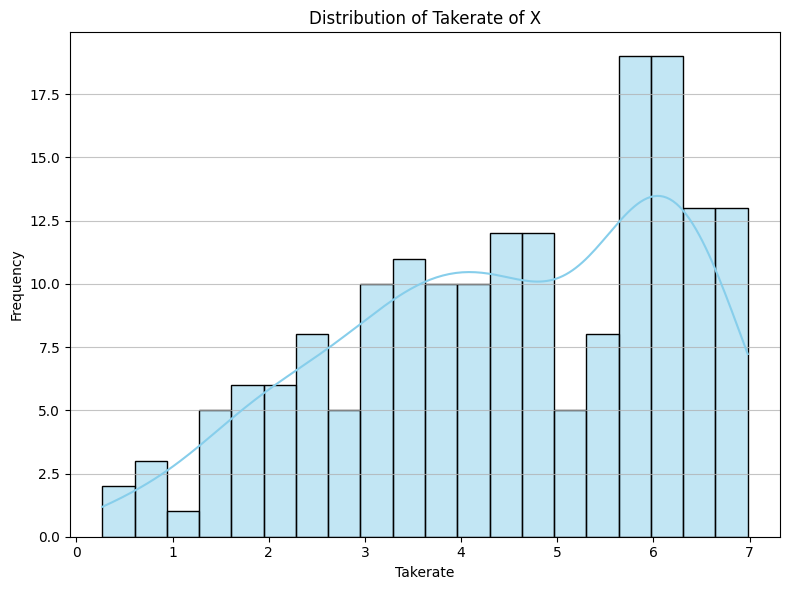

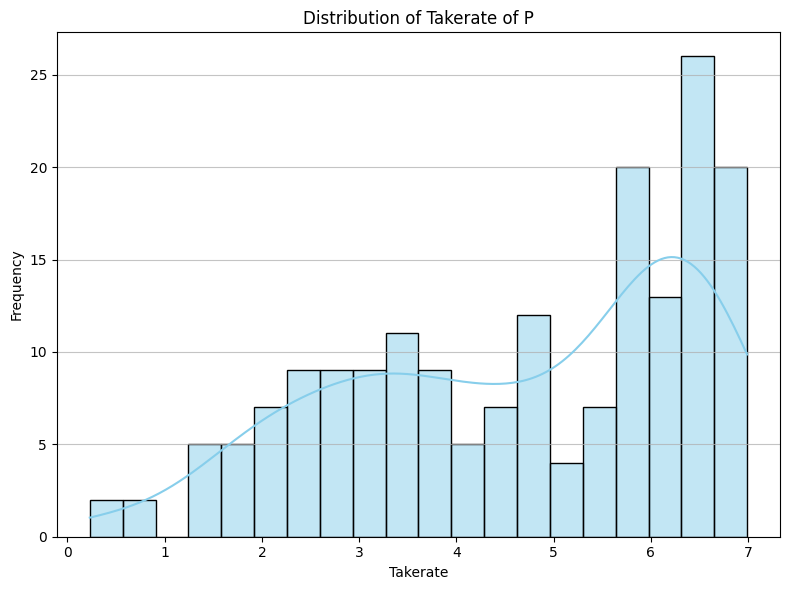

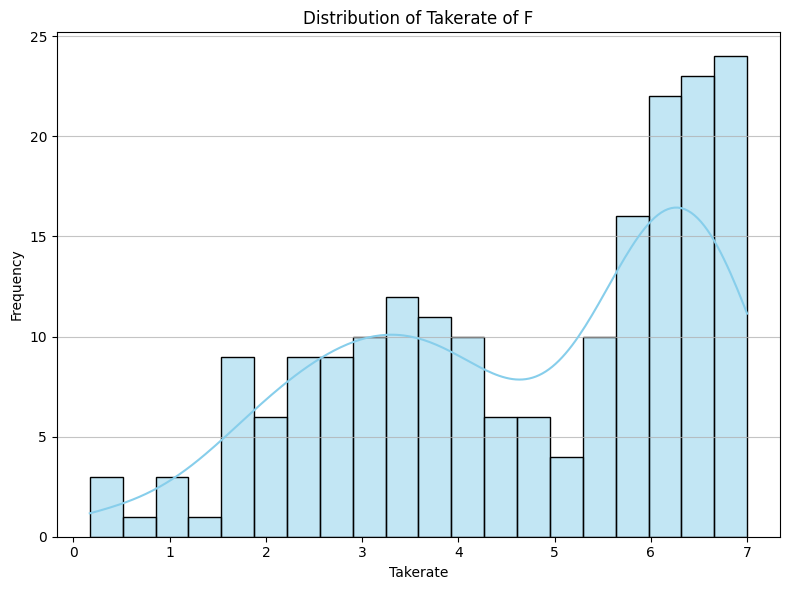

In [16]:
plt.figure(figsize=(8, 6))
industries = top_three_industry_merchants[MAPPED_INDUSTRY].unique()

for industry in industries:
    industry_data = top_three_industry_merchants[top_three_industry_merchants[MAPPED_INDUSTRY] == industry]
    data = industry_data[TAKE_RATE]
    
    plt.figure(figsize=(8, 6))
    sns.histplot(data, bins=20, kde=True, color='skyblue')

    plt.xlabel('Takerate')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Takerate of {industry}')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    
    plt.show()


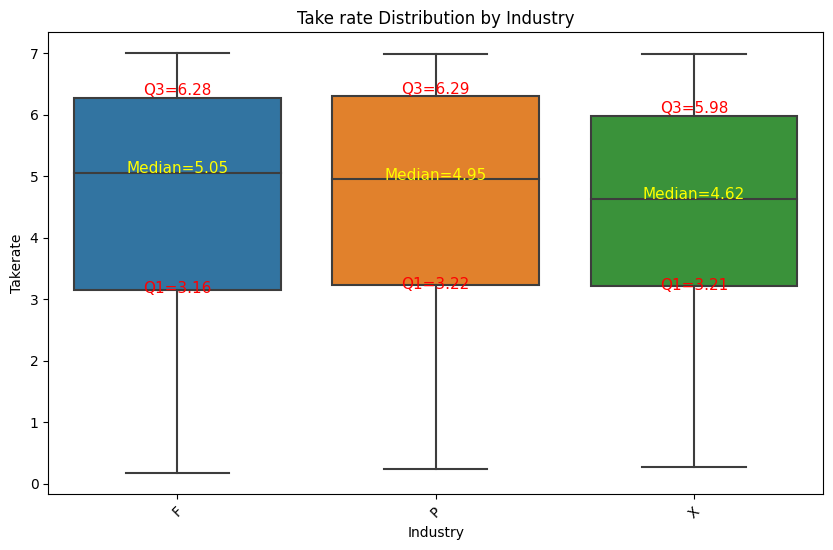

In [17]:
top_three_industry_merchants_ploting = top_three_industry_merchants.sort_values(by=MAPPED_INDUSTRY)

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x=MAPPED_INDUSTRY, y=TAKE_RATE, data=top_three_industry_merchants_ploting)

# adding the Q1, Q3 and median 
q1 = top_three_industry_merchants_ploting.groupby(MAPPED_INDUSTRY)[TAKE_RATE].quantile(0.25)
q3 = top_three_industry_merchants_ploting.groupby(MAPPED_INDUSTRY)[TAKE_RATE].quantile(0.75)
medians = top_three_industry_merchants_ploting.groupby(MAPPED_INDUSTRY)[TAKE_RATE].median()

for xtick in ax.get_xticks():
    ax.text(xtick, q1.iloc[xtick] - 0.05, f'Q1={q1.iloc[xtick]:.2f}', ha='center', color='red', fontsize=11)
    ax.text(xtick, q3.iloc[xtick] + 0.05, f'Q3={q3.iloc[xtick]:.2f}', ha='center', color='red', fontsize=11)
    ax.text(xtick, medians.iloc[xtick], f'Median={medians.iloc[xtick]:.2f}', ha='center', color='yellow', fontsize=11)


plt.xticks(rotation=45)
plt.title('Take rate Distribution by Industry')
plt.xlabel('Industry')
plt.ylabel('Takerate')
plt.savefig(PREFIX + TOP_THREE_INDUSTRY_TAKERATE_PATH)
plt.show()

From the graph above, we can note that the take rate distribution of industry F is the highest and has higher average compared to the other two. 

In [18]:
# we are only interested in the revenue level and the take rate of a merchant

df = top_three_industry_merchants[[MERCHANT_ABN, REVENUE_LEVEL, TAKE_RATE]]

In [20]:
df.to_csv(PREFIX + TOP3_INDUSTRY_REVENUE_TAKERATE_PATH)